https://github.com/Dariusrussellkish/evidential-deep-learning/blob/pytorch_implementation/evidential_deep_learning/pytorch/layers/dense.py

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import Normal
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

import gif
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Set device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\users\pablo\appdata\local\programs\python\python38\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [23]:
from FullyConnectedModel import EvidentialRegression
model = EvidentialRegression(1)

## Losses

https://github.com/Dariusrussellkish/evidential-deep-learning/blob/pytorch_implementation/evidential_deep_learning/pytorch/losses/continous.py

In [5]:
def NIG_NLL(y, gamma, nu, alpha, beta):
    omega = 2 * beta * (1 + nu)
    nll = 0.5 * (np.pi / nu).log()\
            - alpha*omega.log()\
            + (alpha + 0.5) * (nu * (y - gamma) ** 2 + omega).log() \
            + torch.lgamma(alpha) \
            - torch.lgamma(alpha + 0.5)
    return nll.mean()

def NIG_Regularization(y, gamma, nu, alpha):
    error = (y - gamma).abs()
    evidence = 2 * nu + alpha
    return (error * evidence).mean()

def EvidentialRegressionLoss(y, evidential_output, lambda_coef):
    gamma, nu, alpha, beta = evidential_output
    loss_nll = NIG_NLL(y, gamma, nu, alpha, beta)
    loss_reg = NIG_Regularization(y, gamma, nu, alpha)
    return loss_nll, loss_reg

## Hyperparameters

In [9]:
learning_rate = 1e-3
lambda_coef = torch.Tensor([1e-2])
epsilon = 1e-2
maxi_rate = 1e-4
batch_size = 64
num_epochs = 500

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=epsilon)

## Generate Cubic Data

In [11]:
def generate_cubic(x, noise=False):
    x = x.astype(np.float32)
    y = x**3

    if noise:
        sigma = 3 * np.ones_like(x)
    else:
        sigma = np.zeros_like(x)
    r = np.random.normal(0, sigma).astype(np.float32)
    return y+r, sigma

In [12]:
train_bounds = [[-4, 4]]
n_train = 1000
n_test = 1000

x_train = np.concatenate([np.linspace(xmin, xmax, n_train) for (xmin, xmax) in train_bounds]).reshape(-1,1)
y_train, sigma_train = generate_cubic(x_train, noise=True)

test_bounds = [[-7,+7]]
x_test = np.concatenate([np.linspace(xmin, xmax, n_test) for (xmin, xmax) in test_bounds]).reshape(-1,1)
y_test, sigma_test = generate_cubic(x_test, noise=False)

In [13]:
train_dataset = torch.stack([torch.Tensor(x_train), torch.Tensor(y_train)]).squeeze().t()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.stack([torch.Tensor(x_test), torch.Tensor(y_test)]).squeeze().t()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

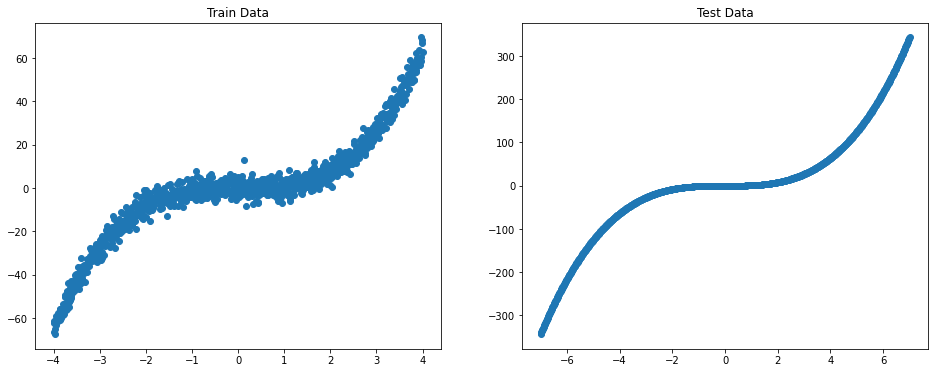

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(x_train, y_train)
ax1.set_title("Train Data")

ax2.scatter(x_test, y_test)
ax2.set_title("Test Data")

plt.show()

In [15]:
def get_prediction(data):
    model.eval()
    preds = []
    with torch.no_grad():
        preds = model(torch.Tensor(data))
    model.train()
    return preds

In [25]:
gif_frames = 50
gif_data = []

loss = 0
nll_loss = 0
reg_loss = 0
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(train_loader):
        data = batch[:,0]
        data = data.reshape(data.shape[0], 1)
        
        targets = batch[:,1]

        data = data.to(device=device)
        targets = targets.to(device=device)
        
        evidential_parameters = model(data)
        nll_loss, reg_loss = EvidentialRegressionLoss(targets, evidential_parameters, lambda_coef)
        loss = nll_loss + lambda_coef * reg_loss

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    if epoch % 100 == 99:
        print("Epoch", epoch + 1, "nll_loss:", nll_loss.item(), "reg_loss:", reg_loss.item(), "Total Loss:", loss.item())
        
    if len(gif_data)*(num_epochs // gif_frames) + num_epochs // gif_frames == epoch + 1:
        gif_data.append(get_prediction(x_test))
loss

Epoch 100 nll_loss: 3.702526807785034 reg_loss: 14.71910285949707 Total Loss: 3.849717855453491
Epoch 200 nll_loss: 2.87907338142395 reg_loss: 6.568602085113525 Total Loss: 2.9447593688964844
Epoch 300 nll_loss: 2.946868419647217 reg_loss: 7.996795654296875 Total Loss: 3.026836395263672
Epoch 400 nll_loss: 2.7926387786865234 reg_loss: 6.219573974609375 Total Loss: 2.85483455657959
Epoch 500 nll_loss: 2.645685911178589 reg_loss: 5.062277793884277 Total Loss: 2.6963086128234863


tensor([2.6963], grad_fn=<AddBackward0>)

In [17]:
@gif.frame
def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = y_pred
#    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
#    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    var = np.minimum(var, 1e3)  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")

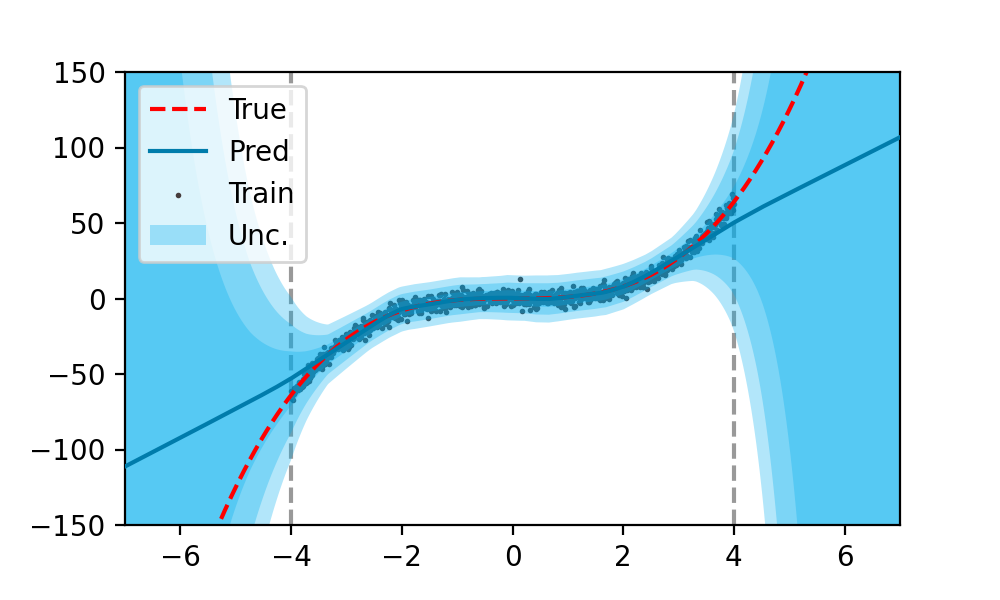

In [18]:
plot_predictions(x_train, y_train, x_test, y_test, gif_data[-1])

In [19]:
frames = [plot_predictions(x_train, y_train, x_test, y_test, stored_preds) for stored_preds in gif_data]
gif.save(frames, "toy_train.gif", duration=gif_frames/6, unit="s", between="startend")

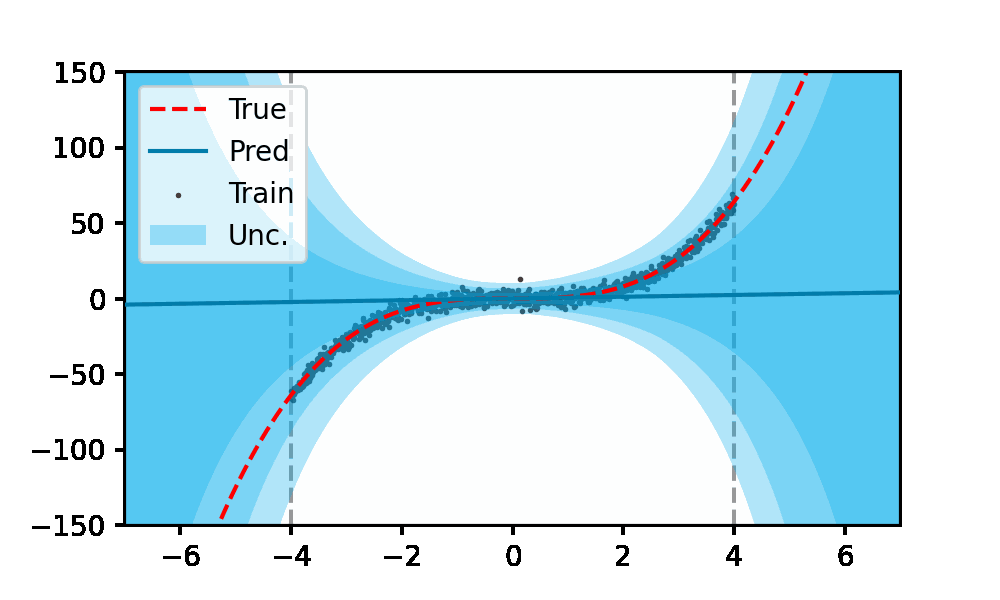

In [20]:
from IPython.display import Image
Image(open("toy_train.gif", "rb").read())